# Image Classification with Deep Learning Project
***

**Author:** Ron Lodetti Jr.
![Heart](./images/heart.jpeg)

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

In [ ]:
%load_ext autoreload
%autoreload 2
from my_modules import data_understanding, data_prep, data_modeling
from tensorflow.keras import models, layers, metrics, callbacks, regularizers
from tensorflow.keras.models import load_model
import pandas as pd
import tensorflow as tf
import numpy as np
import random

# Set the random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Data Understanding
***
The dataset originally comes from Kermany et al. on [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3). I downloaded the data from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) as it had already separated out the chest x-ray images from other data in the original dataset.

The following description is taken directly from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia):
>The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
>
>Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
>
>For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.


Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.

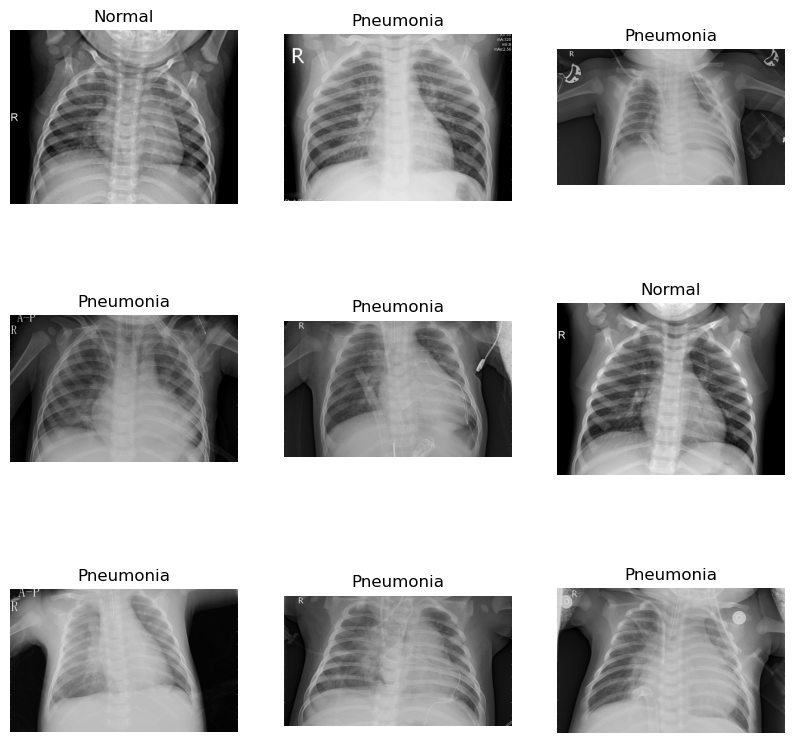

In [13]:
normal_dir = 'data/chest_xray/train/NORMAL/'
pneumonia_dir = 'data/chest_xray/train/PNEUMONIA/'

data_understanding.show_images(normal_dir,pneumonia_dir)

In [23]:
data_dir = 'data/chest_xray'
folders = ['train', 'val', 'test']
df = data_understanding.prepare_plot(data_dir,folders)
df

,Dataset,Normal,Pneumonia,Total
0,train,1341,3875,5216
1,val,8,8,16
2,test,234,390,624


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### 1. Redistribute Data

In [1]:
# Run the run_redistribution function from the data_prep module
# data_prep.run_redistribution()

### 2. Visualizations of before and after

In [24]:
new_folders = ['new_train', 'new_val', 'new_test']
new_df = du.prepare_plot(data_dir,new_folders)
new_df

,Dataset,Normal,Pneumonia,Total
0,new_train,1266,3418,4684
1,new_val,158,427,585
2,new_test,159,428,587


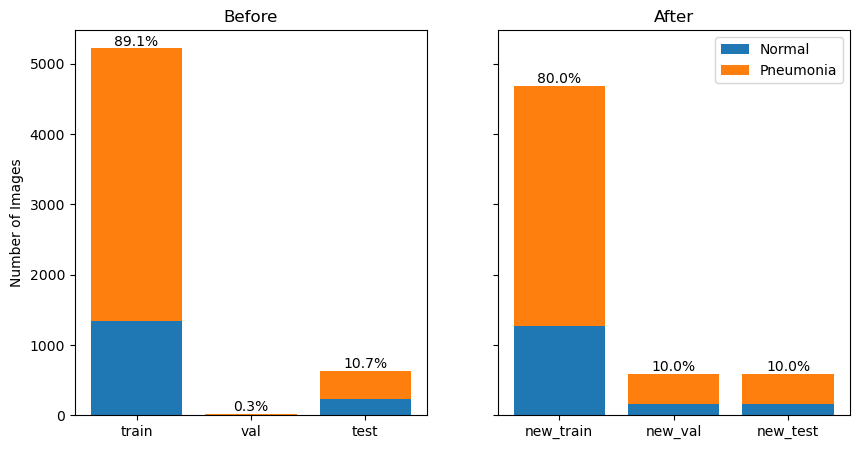

In [25]:
data_prep.compare_bar(df, new_df)

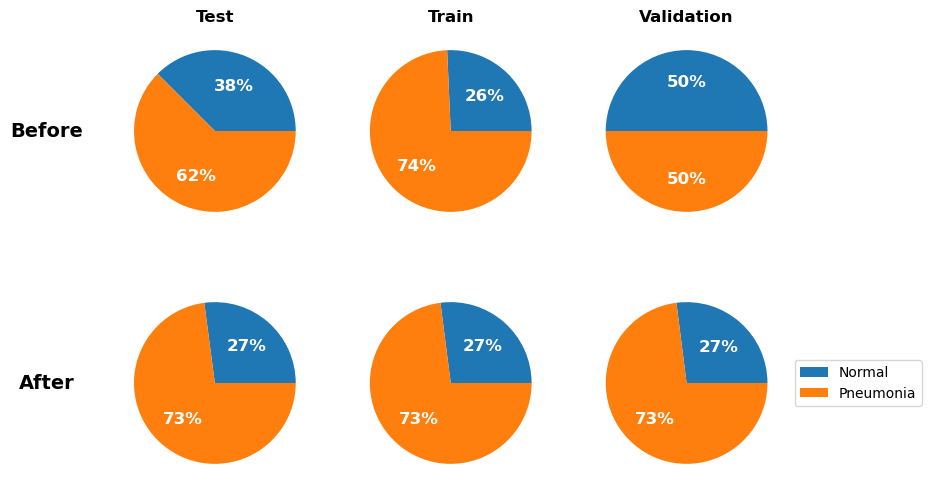

In [27]:
data_prep.pie(df, new_df)

###  3. Show image sizes data

In [ ]:
train_dir = 'data/chest_xray/new_train'
val_dir = 'data/chest_xray/new_val'

train_widths, train_heights = data_prep.get_image_sizes(train_dir)
test_widths, val_heights = data_prep.get_image_sizes(val_dir)

widths = concatenate((train_widths, val_widths))
heights = concatenate((train_heights, val_heights))

AVG_RATIO = data_prep.print_image_statistics(widths, heights)

###  4. Create Dataset

In [ ]:
preprocessed_train_ds = data_prep.create_dataset(train_dir, ratio=AVG_RATIO, process=False, is_training=True)

###  5. Display images after resizing

In [ ]:
data_prep.show_images(preprocessed_train_ds)

###  6. Process data

In [ ]:
rescale = layers.Rescaling(1./255)
train_ds_scaled = preprocessed_train_ds.map(lambda x, y: (rescale(x), y))

###  7. Display images after processing

In [ ]:
data_prep.show_images(train_ds_scaled)

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

Questions to consider:

How did you analyze or model the data?
How did you iterate on your initial approach to make it better?
Why are these choices appropriate given the data and the business problem?

In [12]:
train_ds = data_prep.create_dataset(train_dir, ratio=AVG_RATIO, process=True, is_training=True)
val_ds = data_prep.create_dataset(val_dir, ratio=AVG_RATIO, process=True, is_training=False)

for inputs, labels in train_ds.take(1):
        input_shape = inputs.shape[1:]
        break

Found 4684 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Found 587 files belonging to 2 classes.


For metrics, I chose Recall to emphasise the importance of minimizing false negatives, aka identifyijng a sick patient as healthy. I also included the Area under the ROC to give insight into the model's overall performance and to guard against merely labeling all cases as positive to achieve a high recall.

In [25]:
METRICS = [
    metrics.AUC(name='auc'),
    metrics.Recall(name='recall'),
    metrics.BinaryAccuracy(name='accuracy')]

### Baseline Model
For my baseline model I decided to use a simple neural network with no hidden layers. 

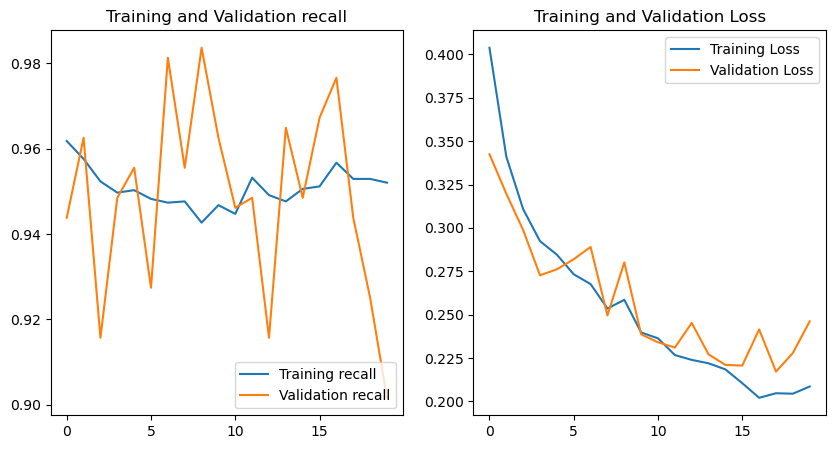

,loss,recall,AUC
baseline,0.2461,0.9016,0.9565


In [38]:
baseline_model = models.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')]) # using sigmoid activation and one node in my output layer for binary classification

# Choosing the 'Adam' optimizer for efficiencty.
# Choosing 'binary_crossentropy' as loss function given bineary classification. 
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# loading model instead of running.
# results = model.fit(train_ds, epochs=20, validation_data=val_ds)

data_modeling.summary_viz('baseline', val_ds)

### Initializers
After my simple baseline model I decided to experiment with different initializers to help my model start off from a better position, which can lead to faster convergence and potentially better overall performance.

In [35]:
file_names = ['model_I1','model_I2']
model_names = ['he_normal', 'lecun_normal']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
he_normal,0.2118,0.9508,0.9622
lecun_normal,0.2128,0.9696,0.9638


Given the similarity in results, I decided to go with 'he_normal' as it is generally recommended for layers with 'relu' activation. I'll be sure to test this again later. 

### Building Complex Model
At this point I decided to add layers and nodes to my model to help it to see any patterns that may exist, even at the risk of over fitting the data. 

I began by adding more nodes and dense layers. Then I built a Convolution Neural Network, adding layers and nodes until I reached a complex enough model and noticed overfitting.  

In [39]:
file_names = ['model_2','model_3','model_5','model_6','model_7']
model_names = ['Dense: more nodes','Dense: 3 layers','Conv: 1 layer','Conv: 2 layers','Conv: 3 layers']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
Dense: more nodes,0.2243,0.9766,0.9690
Dense: 3 layers,0.1829,0.9602,0.9727
Conv: 1 layer,0.2505,0.9766,0.9735
Conv: 2 layers,0.3926,0.9696,0.9661
Conv: 3 layers,0.3567,0.9813,0.9703


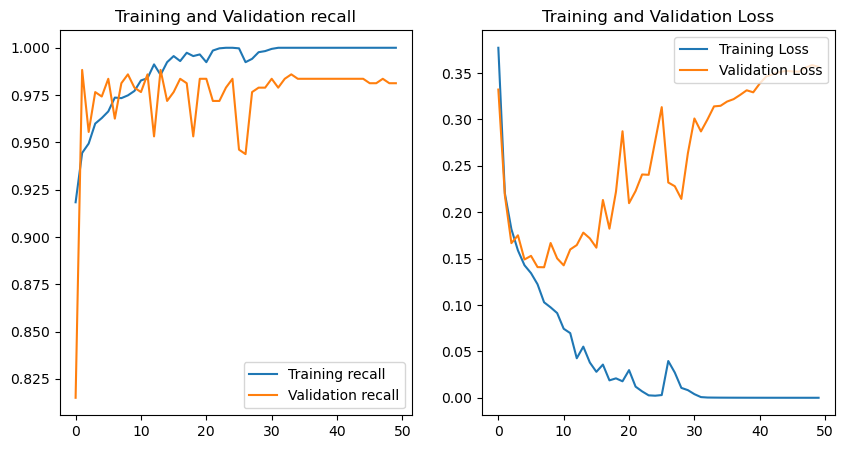

,loss,recall,AUC
baseline,0.3567,0.9813,0.9703


In [40]:
overfit_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', input_shape= input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',kernel_initializer='he_normal'),
    layers.Dense(1, activation='sigmoid')
])

overfit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# loading model instead of running.
# results = overfit_model.fit(train_ds, epochs=20, validation_data=val_ds)
data_modeling.summary_viz('model_7', val_ds)

### Optimizers
Now that I added complexity to my model I began experimenting with optimizers to see how they affect how quickly and effectively the model learns. I began using early stopping here stop the model from training after it doesn't see significant improvement in the validation loss metric. 

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', # metric to monitor for improvment. 
                               min_delta=0.001, # minimum improvement.
                               patience=10, # how long it will wait to see improvment
                               mode='min', 
                               restore_best_weights=True, # after 10 epochs without improvement, it will restore the model with the best weights. 
                               verbose=1)

After evaluating Adam, RMSprop, and SGD optimizers using their default learning rates, I selected the SGD optimizer. This decision was based on its superior ability to quickly learn from the training data. Further experimentation with various learning rates [0.1, 0.01, 0.001] and momentum values [0, 0.5, 0.9, 0.99] led me to choose a learning rate of 0.01 and a momentum of 0.9 for SGD. This configuration achieved the fastest convergence and the lowest validation loss. Notably, it maintained training stability, unlike the higher momentum value of 0.99, which resulted in unstable training.

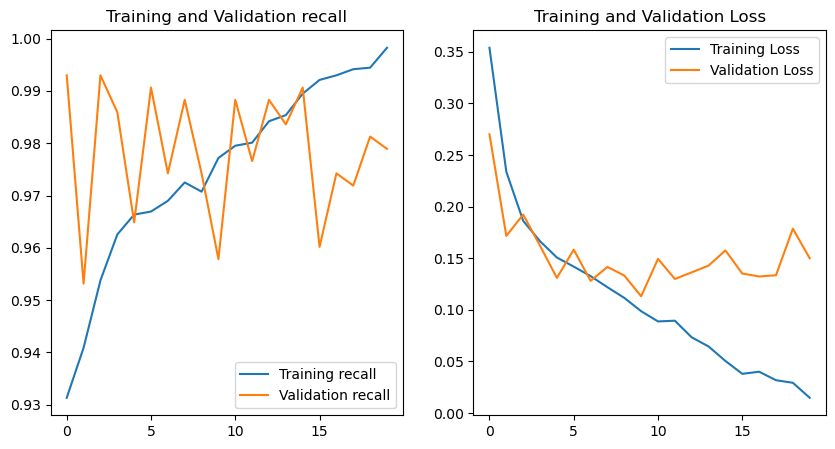

,loss,recall,AUC
baseline,0.1131,0.9578,0.9879


In [48]:
data_modeling.summary_viz('model_O8', val_ds)

### Note: Stop x axis where early stopping stops

### Regularization
Since I have a model that is overfitting, I applied regularization methods, such as dropout, L1/L2 regularization, and data augmentation, help in making the model less sensitive to the specific details of the training data, encouraging it to learn more generalized patterns that apply to unseen data as well.

#### Dropout Layers
After experimenting with the placement of dropout layers and adjusting their rates, I determined the optimal configuration for my model involves situating dropout layers immediately following the Conv2D layers and one before the output layer, applying a dropout rate of 0.25. This arrangement effectively prevents overfitting by introducing regularization right after feature extraction in the convolutional layers and prior to the final classification, enhancing the model's ability to generalize from the training data.

In [57]:
file_names = ['model_R1','model_R2','model_R3','model_R4','model_R5','model_R6']
model_names = ['After MaxPooling','After Conv','After Dense','After Max and Dense','After Conv and Dense','After Conv and Dense with 0.5']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
After MaxPooling,0.1122,0.9578,0.9915
After Conv,0.1062,0.9883,0.9911
After Dense,0.1132,0.9836,0.9858
After Max and Dense,0.1113,0.9719,0.9910
After Conv and Dense,0.0901,0.9836,0.9933
After Conv and Dense with 0.5,0.1422,0.9766,0.9893


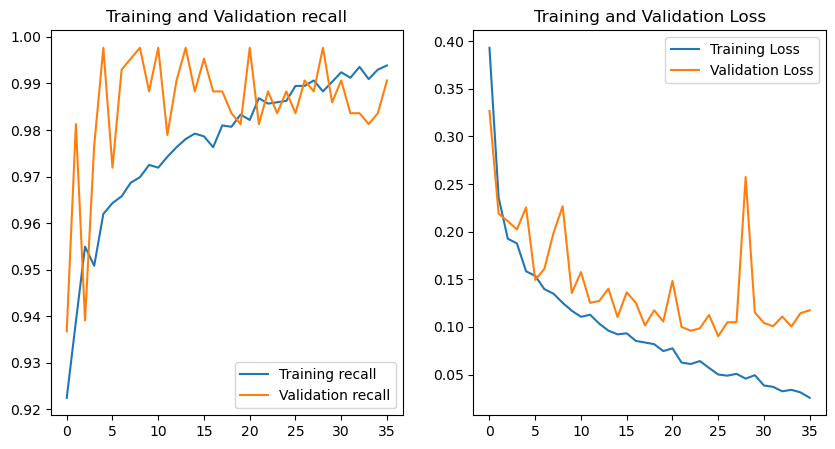

,loss,recall,AUC
baseline,0.0901,0.9836,0.9933


In [61]:
dropout_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', input_shape= input_shape),
    layers.Dropout(0.25),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.Dropout(0.25),    
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.Dropout(0.25),    
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), 
                      loss='binary_crossentropy', 
                      metrics=METRICS)

# loading model instead of running.
# dropout_results = dropout_model.fit(train_ds, epochs=50, validation_data=val_ds, 
#                                     early_stopping= early_stopping)

data_modeling.summary_viz('model_R5', val_ds)

#### L1/L2 Regularization
L2 clearly outperformed L1 regularization.

In [54]:
file_names = ['model_R7','model_R8']
model_names = ['L1','L2']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
L1,1.7340,1.0000,0.5000
L2,0.2134,0.9696,0.9827


#### Data Augmentation
The best data augmentation seemed to be RandomRotation, with a slightly better AUC & Recall. It also converged faster than RandomFlip.

In [55]:
file_names = ['model_R9','model_R10','model_R11','model_R12']
model_names = ['RandomFlip','RandomRotation','RandomZoom','Combination']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
RandomFlip,0.1087,0.9813,0.9885
RandomRotation,0.1107,0.9836,0.9908
RandomZoom,0.1173,0.9578,0.9888
Combination,0.1172,0.9813,0.9888


#### Combinations
Attemping combinations of the most effective regularization methods to see if we can find any improvement. 

In [64]:
file_names = ['model_R13','model_R14','model_R15','model_R16']
model_names = ['Dropout, L2, & Rotation ','Dropout & L2','Dropout & Rotation','L2 & Rotation']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
"Dropout, L2, & Rotation",0.3387,0.9883,0.9743
Dropout & L2,0.1904,0.9930,0.9859
Dropout & Rotation,0.1315,0.9625,0.9886
L2 & Rotation,0.2033,0.9461,0.9830


Ultimately, I chose the Dropout "After Conv & Dense" model shown above as the best regularization method based on metrics observed.

### Final Adjustments
Once I found a more stable model, I decided to revisit both initializers and optimizers again, just to see if we could improve our results.

In [63]:
file_names = ['model_LA1', 'model_LA2', 'model_LA3', 'model_LA4']
model_names = ['Adam', 'RMSprop', 'No Initializer', 'Lecun_normal']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
Adam,0.1072,0.9625,0.9924
RMSprop,0.1285,0.9859,0.9875
No Initializer,0.1033,0.9859,0.9896
Lecun_normal,0.1016,0.9836,0.9907


### Final model
In the end, the Dropout "After Conv & Dense" model performed the best. 

In [42]:
final_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 85, 32)        320       
                                                                 
 dropout_14 (Dropout)        (None, 62, 85, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 42, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 40, 64)        18496     
                                                                 
 dropout_15 (Dropout)        (None, 29, 40, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 20, 64)        0         
 ng2D)                                                

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

In [1]:
test_dir = "data/chest_xray/new_test"
test_ds = data_prep.create_dataset(test_dir, ratio=AVG_RATIO, process=True, is_training=False)

2024-03-06 11:19:07.543569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 587 files belonging to 2 classes.


In [2]:
baseline_model = load_model('saved_models 2/baseline.keras')
baseline_score = baseline_model.evaluate(test_ds)
print(baseline_score)

19/19 [==============================] - 1s 2ms/step - loss: 0.2914 - auc: 0.9449 - recall: 0.8388 - accuracy: 0.8671
[0.29140612483024597, 0.9448950886726379, 0.8387850522994995, 0.8671209812164307]


In [10]:
loss = round(baseline_score[0],4)
recall = round(baseline_score[2],4)
AUC = round(baseline_score[1],4)
name = 'baseline'
df = pd.DataFrame([[loss,recall,AUC]],columns=['loss','recall','AUC'],index=[name])
display(df)

,loss,recall,AUC
baseline,0.2914,0.8388,0.9449


In [3]:
overfit_model = load_model('saved_models 2/model_8.keras')
overfit_score = overfit_model.evaluate(test_ds)
print(overfit_model)

19/19 [==============================] - 1s 30ms/step - loss: 0.1365 - auc: 0.9861 - recall: 0.9603 - accuracy: 0.9506


In [4]:
final_model = load_model('saved_models 2/final_model.keras')
final_score = final_model.evaluate(test_ds)
print(final_model)

19/19 [==============================] - 1s 30ms/step - loss: 0.1089 - auc: 0.9911 - recall: 0.9720 - accuracy: 0.9557


## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

NOTES: maybe split betwen bacteria or virus, gather more data obv